<a href="https://colab.research.google.com/github/paulomarc49/ETo_climate/blob/main/ETo_weather_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Data Loading

### 1.1. The data of year 2021 and 2022 was previus treated, joined and saved as a numpy file in a Linux system.
### 1.2. The data rest in the google drive repository:

 * **2021 2022:** https://drive.google.com/file/d/1-SLYUEciTHd4OCSbqXoJ6fdOaYIGl_ao/view?usp=sharing

In [1]:
import numpy as np
import pandas as pd
import joblib
import os
from tqdm import tqdm

# Load preprocessed data for the years 2021 and 2022 as a NumPy array.
# If Drive access is unavailable, download the data from the provided links and edit your directory.

numpy_data_2021_2022 = np.load('/content/drive/MyDrive/ETo/2021_2022_numpy.npy')
print('The input data has the shape: ', numpy_data_2021_2022.shape)

# Reduce the size of the files
numpy_data_2021_2022 = numpy_data_2021_2022.astype(np.float16)

# Save reduced size data
folder_path = '/content/ETo_weather_training'
os.mkdir(folder_path)
outpath = '/content/ETo_weather_training/2021_2022_numpy_float16.npy'
np.save( outpath, numpy_data_2021_2022, allow_pickle=False )

The input data has the shape:  (512302320, 8)


In [2]:
# Load preprocessed data of years 2021 and 2022 like NumPy.float16 array:
numpy_data_2021_2022 = np.load('/content/ETo_weather_training/2021_2022_numpy_float16.npy')
print('ETo weather variables has the shape: ', numpy_data_2021_2022.shape)

# Convert NumPy array into Pandas dataframe:
pandas_data_2021_2022 = pd.DataFrame(numpy_data_2021_2022, columns=['Net radiation',
                                                                    'Ground Flux',
                                                                    'Air temperature',
                                                                    'Slope vapour pressure curve',
                                                                    'Psychrometric const',
                                                                    'Saturation vapour pressure',
                                                                    'Actual vapour pressure',
                                                                    'Wind speed magnitude'])

pandas_data_2021_2022

ETo weather variables has the shape:  (512302320, 8)


,Net radiation,Ground Flux,Air temperature,Slope vapour pressure curve,Psychrometric const,Saturation vapour pressure,Actual vapour pressure,Wind speed magnitude
0,-0.687988,0.005627,22.312500,0.163940,0.065308,2.695312,2.447266,1.781250
1,-0.710938,0.006733,22.234375,0.163208,0.065125,2.681641,2.437500,1.888672
2,-0.691406,0.007935,22.250000,0.163330,0.065430,2.683594,2.447266,1.823242
3,-0.701660,0.012787,22.281250,0.163574,0.065918,2.689453,2.468750,1.716797
4,-0.707031,0.014496,22.265625,0.163452,0.066162,2.687500,2.484375,1.420898
...,...,...,...,...,...,...,...,...
512302315,0.076294,0.009140,25.234375,0.190918,0.066223,3.210938,3.021484,0.835449
512302316,0.076355,0.009338,25.203125,0.190796,0.066223,3.207031,3.029297,0.849609
512302317,0.076782,0.008713,25.218750,0.190796,0.066223,3.208984,3.033203,0.847168
512302318,0.076538,0.008179,25.218750,0.190918,0.066223,3.210938,3.031250,0.847168


## 2. SOM

* The project is based in a custom sci-kit learn SOM

In [3]:
# Installing sci-kit learn SOM package

!pip install sklearn-som
!pip install joblib

# Making Custom sci-kit learn SOM package

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn_som.som import SOM as SklearnSOM

class CustomSOM(BaseEstimator, ClusterMixin):
    def __init__(self, m=1, n=1, dim=1, sigma=1.7, lr=1, max_iter=10, random_state=None):
        self.m = m
        self.n = n
        self.dim = dim
        self.sigma = sigma
        self.lr = lr
        self.max_iter = max_iter
        self.random_state = random_state
        self.model_ = None

    def fit(self, X, y=None):
        self.model_ = SklearnSOM(m=self.m, n=self.n, dim=self.dim, lr=self.lr, max_iter=self.max_iter, random_state=self.random_state)
        self.model_.fit(X)
        return self

    def predict(self, X):
        return self.model_.predict(X)

    def transform(self, X):
        return self.model_.transform(X)

    def score(self, X, y=None):
        distancias_punto_centroide = self.transform(X)
        distorsion_total = 0
        for i in range(len(distancias_punto_centroide)):
            distancias_minimas_cuadradas = (np.min(distancias_punto_centroide[i]))**2
            distorsion_total += distancias_minimas_cuadradas
        return distorsion_total

## 3. Training the model


In [4]:
from sklearn.preprocessing     import StandardScaler
from sklearn.pipeline          import Pipeline

### 3.1. Training one day data for model review using sci-kit learn pipelines

In [5]:
# Function for plotting one day SOM clusters:

def plot_one_day(numpy_data, labels):
    d, x, y, n_variables = 30, 171, 171, 192
    classes = labels
    # Flattering original array
    variables_flat = numpy_data
    variables_flat = variables_flat[0:701784]
    print(f"Input data flattered shape: {variables_flat.shape}")
    # Reshape labels array
    classes = classes.reshape(-1, 1)
    classes = classes[0:701784]
    print(f"Output layer label:         {classes.shape}")
    # Join of flattered original array and labels array
    array_con_etiquetas = np.concatenate((variables_flat, classes), axis=-1)
    print(f"Joined array:               {array_con_etiquetas.shape}")
    # Reshape of joined array
    array_con_etiquetas = array_con_etiquetas.reshape(1, 24, x, y,9)
    array_con_etiquetas = array_con_etiquetas.transpose(0, 2, 3, 1, 4)
    array_con_etiquetas = array_con_etiquetas.reshape(1*x, y, 24*9)
    print(f"Reshaped joined array:      {array_con_etiquetas.shape}")
    # Plot code
    import matplotlib.pyplot as plt
    data = array_con_etiquetas[:,:,107] # Plot at noon
    plt.figure(figsize=(5, 4))
    plt.imshow(data, cmap='gnuplot2', interpolation='bilinear')
    plt.colorbar(label='ETo clusters')
    plt.title(f'ETo wheather heatmap with distortion: {distortion}')
    plt.xlabel('Pixel X')
    plt.ylabel('Pixel Y')
    plt.show()

The one day data has a size of:  5614272
Input data flattered shape: (701784, 8)
Output layer label:         (701784, 1)
Joined array:               (701784, 9)
Reshaped joined array:      (171, 171, 216)


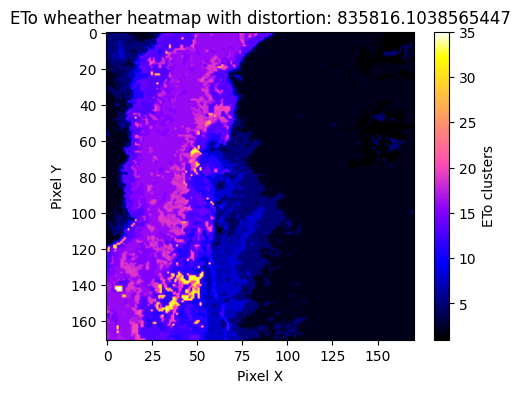

In [ ]:
# Filtering original 2 years data to one day
pandas_data_one_day = pandas_data_2021_2022.iloc[0:701784]
numpy_data_one_day  = numpy_data_2021_2022[0:701784]
print('The one day data has a size of: ', pandas_data_one_day.size)

# Train the one day data model with pipeline
from tqdm import tqdm
model_SOM_2 = Pipeline([('scal', StandardScaler()),
                        ('som', CustomSOM(m=12,
                                          n=3,
                                          dim=8,
                                          lr=1.491,
                                          max_iter=90,
                                          random_state=42))
                       ])

SOM_train_inicial = model_SOM_2[:-1].fit_transform(pandas_data_one_day)
SOM_train         = model_SOM_2[-1].fit(SOM_train_inicial)
labels_SOM_train  = model_SOM_2.named_steps['som'].predict(SOM_train_inicial)
distortion        = model_SOM_2.named_steps['som'].score(SOM_train_inicial)

plot_one_day(numpy_data_2021_2022, labels_SOM_train)

### 3.2. Training two years data

In [6]:
print('The two years data has a size of: ', pandas_data_2021_2022.shape)
scaler = StandardScaler()
SOM_train_inicial = scaler.fit_transform(pandas_data_2021_2022)

# Save normalized data
outpath = '/content/ETo_weather_training/2021_2022_numpy_normalized.npy'
np.save( outpath, SOM_train_inicial, allow_pickle=False )

The two years data has a size of:  (512302320, 8)


In [7]:
# Load the normalized data
SOM_train_inicial = np.load('/content/ETo_weather_training/2021_2022_numpy_normalized.npy')
print('The two years normalized data has a size of: ', SOM_train_inicial.shape)

The two years normalized data has a size of:  (512302320, 8)


In [ ]:
# Train the custom sci-kit learn SOM model:
dim = 8
som_model = CustomSOM(m=12, n=3, dim=8, lr=1.491, max_iter=90, random_state=42)
som_model.fit(SOM_train_inicial)

import joblib
# Save the trained SOM model
joblib.dump(som_model, '/content/ETo_weather_training/som_model_fit.pkl')

In [9]:
from joblib import Parallel, delayed
import numpy as np
import os

# Function to predict SOM labels for a chunk of data
def predict_chunk(som_model, data_chunk):
    return som_model.predict(data_chunk)

# Function to divide the data into chunks and process them in parallel
def process_data_in_parallel(som_model, data, n_jobs=-1, chunk_size=None):
    n_samples = data.shape[0]
    if chunk_size is None:
        chunk_size = n_samples // 90  # Default to dividing data into 10 chunks if not provided
    data_chunks = [data[i:i + chunk_size] for i in range(0, n_samples, chunk_size)]

    # Parallel processing of each chunk
    results = Parallel(n_jobs=n_jobs)(
        delayed(predict_chunk)(som_model, chunk) for chunk in data_chunks
    )

    # Join the predicted labels
    return np.concatenate(results)

# Predictions and labels generation
outpath_ETo_weather_labels = '/content/ETo_weather_training/2021_2022_numpy_labels.npy'

# Check if the labels file already exists
if not os.path.exists(outpath_ETo_weather_labels):
    # Process data in parallel and predict labels
    som_model = joblib.load('/content/ETo_weather_training/som_model_fit.pkl') #If do not want to train new model can download the trained one from: https://drive.google.com/file/d/1E771bVe5fM3JDX-otPUqUdcIXk0l-lJ-/view?usp=drive_link
    labels_SOM_train = process_data_in_parallel(som_model, SOM_train_inicial)
    # Save the labels array
    np.save(outpath_ETo_weather_labels, labels_SOM_train.astype(np.int16), allow_pickle=False)
    print(f'Labels array saved to: {outpath_ETo_weather_labels}')
else:
    print(f'File already exists at {outpath_ETo_weather_labels}, ')

Labels array saved to: /content/ETo_weather_training/2021_2022_numpy_labels.npy


In [10]:
# Join of labels and original dataset
outpath_ETo_weather = '/content/ETo_weather_training/ETo_weather_2021_2022.npy'

if not os.path.exists(outpath_ETo_weather):
    labels_SOM_train = np.load('/content/ETo_weather_training/2021_2022_numpy_labels.npy')
    labels_SOM_train = labels_SOM_train.astype(np.int16)
    ETo_weather = np.concatenate((numpy_data_2021_2022, labels_SOM_train.reshape(-1,1)), axis=1)
    np.save(outpath_ETo_weather, ETo_weather, allow_pickle=False)
    print(f'Labels array saved to: {outpath_ETo_weather}')
    print('ETo weather shape is: ', ETo_weather.shape)
else:
    print(f'File already exists at {outpath_ETo_weather}, ')

Labels array saved to: /content/ETo_weather_training/ETo_weather_2021_2022.npy
ETo weather shape is:  (512302320, 9)


In [12]:
d, x, y, n_variables = 730, 171, 171, 192

outpath_ETo_weather_reshaped = '/content/ETo_weather_training/ETo_weather_reshaped_2021_2022.npy'
if not os.path.exists(outpath_ETo_weather_reshaped):
    ETo_weather = np.load('/content/ETo_weather_training/ETo_weather_2021_2022.npy')
    print(f"Original data shape: {ETo_weather.shape}")
    ETo_weather_reshaped = ETo_weather.reshape(d, 24, x, y, 9)  # ok
    print(f"Shape 2 of the original array with labels: {ETo_weather_reshaped.shape}")
    ETo_weather_reshaped = ETo_weather_reshaped.transpose(0, 2, 3, 1, 4)
    print(f"Shape 3 of the original array with labels: {ETo_weather_reshaped.shape}")
    ETo_weather_reshaped = ETo_weather_reshaped.reshape(d * x, y, 24 * 9)
    print(f"Final shape of the original array with labels: {ETo_weather_reshaped.shape}")
    np.save(outpath_ETo_weather_reshaped, ETo_weather_reshaped, allow_pickle=False)
else:
    print(f'File already exists at {outpath_ETo_weather_reshaped}')

Original data shape: (512302320, 9)
Shape 2 of the original array with labels: (730, 24, 171, 171, 9)
Shape 3 of the original array with labels: (730, 171, 171, 24, 9)
Final shape of the original array with labels: (124830, 171, 216)


## 4. Visualization and simulation

In [13]:
ETo_weather_reshaped = np.load('/content/ETo_weather_training/ETo_weather_reshaped_2021_2022.npy')
print('The two year data and layers has a size of: ', ETo_weather_reshaped.shape)

The two year data and layers has a size of:  (124830, 171, 216)


In [14]:
%matplotlib inline

!pip install ipywidgets>=7,<8

import numpy              as np
import ipywidgets         as widgets
import matplotlib.pyplot  as plt
import joblib
from IPython.display      import display
from PIL                  import Image
from matplotlib.widgets   import Cursor
from tqdm                 import tqdm
from google.colab         import output

/bin/bash: line 1: 8: No such file or directory


In [35]:
output.enable_custom_widget_manager()
dropdown = widgets.Dropdown(
    options=[('Net radiation', 0),
             ('Ground Flux', 1),
             ('Air temperature at 2 m', 2),
             ('Slope vapour pressure curve', 3),
             ('Psychrometric const', 4),
             ('Saturation vapour pressure', 5),
             ('Actual vapour pressure', 6),
             ('Wind speed magnitude at 2m', 7),
             ('ETo Weather Clusters', 8)],
    value=8,
    description='VARIABLES:',
)

dropdown1 = widgets.IntSlider(min=0, max=23, step=1, description='HOUR:')
dropdown2 = widgets.IntSlider(min=1, max=730, step=1, description='DAY:')

play = widgets.Play(
    value=0,
    min=0,
    max=729,
    step=1,
    interval=2500,
    description="Press play",
    disabled=False
)

def Dropdown_Menu(value=1, hora=1, dia=1):
    fig, (ax,ax2) = plt.subplots(1, 2, figsize=(9, 3))
    fig.dpi = 140

    x = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    y = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
    z = lista = list(range(0, 729))

    pos = x.index(value)
    horas = y.index(round(hora))
    dias = z.index(round(dia))

    dia1 = ETo_weather_reshaped[0 + (171*(dias-1)) : 171 + (171*(dias-1))]

    var_name = ['Net radiation MJ/(m2*hr)', 'Ground Flux MJ/(m2*hr)', 'Air temperature at 2 m °C',
                'Slope vapour pressure curve kPa °C-1', 'Psychrometric const kPa °C-1',
                'Saturation vapour pressure kPa', 'Actual vapour pressure kPa',
                'Wind speed magnitude at 2m m/s', 'ETo Weather Clusters'][pos]

    data = dia1[:,:,round(pos+(horas*9))]
    rad = dia1[:,:,round(0 + (horas*9))]
    flux = dia1[:,:,round(1 + (horas*9))]
    temp = dia1[:,:,round(2 + (horas*9))]
    slope_vapour = dia1[:,:,round(3 + (horas*9))]
    g = dia1[:,:,round(4 + (horas*9))]
    saturation_p = dia1[:,:,round(5 + (horas*9))]
    actual_p = dia1[:,:,round(6 + (horas*9))]
    speed = dia1[:,:,round(7 + (horas*9))]
    ETo_cluster = dia1[:,:,round(8 + (horas*9))]
    ETo = ( (0.408 * slope_vapour * (rad - flux)) + g * ( (37)/(temp + 273) ) * (speed)*(saturation_p - actual_p) ) / (slope_vapour + g * (1 + 0.34 * speed))

    # Clear the axes to update the plots
    ax.clear()
    ax2.clear()

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.4,
                        hspace=0.1)

    scala_inf = [-1.0, -0.05,  5.00, 0.00, 0.03, 0, 0, 0, 0]
    scala_sup = [ 0.9,  0.20, 31.00, 0.25, 0.08, 4, 3, 5, 36]

    titulo_dinamico =  f'\n"{var_name}"'

    im = ax.imshow(data, cmap='gnuplot2', vmin=scala_inf[pos], vmax=scala_sup[pos], alpha=1, interpolation='bilinear')
    im2 = ax2.imshow(ETo, cmap='gnuplot2', vmin=-0.2, vmax=0.3)
    ax.set_title(titulo_dinamico, color="steelblue")
    ax.set_xlabel('Geographic pixel in X axis')
    ax.set_ylabel('Geographic pixel in Y axis')

    ax2.set_title('\n "ETo calculated with Penman-Monteith"', color="steelblue")
    ax2.set_xlabel('Geographic pixel in X axis')
    ax2.set_ylabel('Geographic pixel in Y axis')

    plt.colorbar(im, ax=ax, label=var_name)
    plt.colorbar(im2, ax=ax2, label='ETo (mm/day)')

    plt.show()

widgets.jslink((play, 'value'), (dropdown2, 'value'))

widgets.interact(Dropdown_Menu, value=dropdown, hora=dropdown1, dia=dropdown2)
widgets.HBox([play])


interactive(children=(Dropdown(description='VARIABLES:', index=8, options=(('Net radiation', 0), ('Ground Flux…